In [2]:
!pwd

/home/br/sweethome/ferm/worm_disord/analyze


In [1]:
import io

import pandas as pd
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

## Read in the `res` lines

In [7]:
def read_res(fnames):
    """Read the `res_SUFFIX` files for a collection of replicas."""
    
    firstline = "replica_id density err_density conv_density g_im err_g_im conv_g_im Z(mln)"
    lines = [firstline]

    for fname in fnames:
        with open(fname, 'r') as f:
            line = f.read()
            #line.spline
        lines.append(" ".join(line.split()))

    lines
    buffer = io.StringIO("\n".join(lines))
    df = pd.read_csv(buffer, sep="\s+")
    return df

## Resample

In [3]:
def resample(mean, err, num_samples=100000, seed=1234):
    """Compute the replica average over a `mean` array w/synthetic datasets.
        
    Given two arrays of values and errorbars (one for each replica),
    generate `num_samples` synthetic realizations for each replica. For each realization,
    compute the average value.
    
    Parameters
    ----------
    mean : array_like, shape (n_meas,)
        Mean values, one for each replica.
    err : array_like, shape (n_meas,)
        Errorbars, one for each replica.
    num_samples : int
        Generate sythetic datasets of this many samples
        for each element of `mean` and arr.
    seed : int
        np.random seed for random numbers
        
    Returns
    -------
    ndarray, shape (n_samples,)
        Synthetic dataset: average over the replicas
        
    """
    mean, err = map(np.asarray, (mean, err))
    num_meas = mean.size
    synth = np.empty((num_meas, num_samples), dtype=float)
    
    rndm = np.random.RandomState(seed)
    for j in range(num_meas):
        synth[j, :] = rndm.normal(mean[j], err[j], size=num_samples)
        
    return synth.sum(axis=0) / num_meas

## Convergence analysis: plot `nmnm` distributions

In [4]:
def load_nmnm(fname):
    nmnm = np.loadtxt(fname)
    mask = nmnm[:, 1] > 0
    return nmnm[mask]

def overlay_gaussian(nm):
    """Cook up a gaussian shaped curve with sample 1st and 2nd moments.
    """
    x, y = nm.T
    m1 = (x * y).sum()
    m2 = ((x - m1)**2 * y).sum() 
    
    arr = np.exp(-(x - m1)**2 / 2 / m2)
    arr /= arr.sum()
    return arr 

In [5]:
def plot_nmnm(fnames, fname_unif):
    fig, axx = plt.subplots(len(fnames)//3+1, 3, figsize=(9, 15))

    for fname, ax in zip(fnames, axx.ravel()):
        nm = load_nmnm(fname)

        ax.plot(nm[:, 0], nm[:, 1], 'o')
        ax.plot(nm[:, 0], overlay_gaussian(nm), '-', lw=3)
        ax.set_title( fname.split("/nmnm_")[-1].split(".dat")[0])
        ax.grid(True)
        
        nm_unif = load_nmnm(fname_unif)
        ax.plot(nm_unif[:, 0], nm_unif[:, 1], '--', color='C4')
        
    plt.tight_layout()

# Process L=6


### Analyze $L=6$, $\beta = 3.5$

In [6]:
resdict_L6b35 = {"L": 6, "beta": 3.5}


reslines = !ls ../runs/L6b3.5/res*
print(reslines)
df = read_res(reslines)
df

['../runs/L6b3.5/res_L6b3.5r10a0.1.dat', '../runs/L6b3.5/res_L6b3.5r1a0.1.dat', '../runs/L6b3.5/res_L6b3.5r2a0.1.dat', '../runs/L6b3.5/res_L6b3.5r3a0.1.dat', '../runs/L6b3.5/res_L6b3.5r4a0.1.dat', '../runs/L6b3.5/res_L6b3.5r5a0.1.dat', '../runs/L6b3.5/res_L6b3.5r6a0.1.dat', '../runs/L6b3.5/res_L6b3.5r7a0.1.dat', '../runs/L6b3.5/res_L6b3.5r8a0.1.dat', '../runs/L6b3.5/res_L6b3.5r9a0.1.dat']


replica_id   density  err_density conv_density      g_im  err_g_im  \
0          10  0.177601     0.000430            T  0.076570  0.000694   
1           1  0.169371     0.000412            T  0.070404  0.000408   
2           2  0.168192     0.000379            T  0.069945  0.000648   
3           3  0.171659     0.000410            T  0.072381  0.000572   
4           4  0.184929     0.000334            T  0.083769  0.000645   
5           5  0.163729     0.000312            T  0.066514  0.000375   
6           6  0.180920     0.000503            T  0.080947  0.000638   
7           7  0.159972     0.000315            T  0.063386  0.000330   
8           8  0.181314     0.000412            T  0.080763  0.000716   
9           9  0.159755     0.000274            T  0.062684  0.000394   

  conv_g_im      Z(mln)  
0         T  187.820970  
1         T  319.558336  
2         F  256.019088  
3         T  322.923431  
4         T  218.616277  
5         T  368.362091  
6         T  179.530532  
7         T  396.708176  
8         T  175.597718  
9         T  409.722178

In [7]:
sum(df["g_im"])/len(df["g_im"])

0.07273627860259191

In [8]:
samples = resample(df["g_im"], df["err_g_im"])

plt.hist(samples, density=True, bins=100, histtype='step')

m, s = samples.mean(), samples.std()

plt.axvline(m, lw=5, color='C1')
plt.axvspan(m-s, m+s, alpha=0.4, color='C1')

print(m, '+/-', s)
resdict_L6b35["g_im"] = m
resdict_L6b35["err_g_im"] = s

<IPython.core.display.Javascript object>

0.07273619241738194 +/- 0.0001769013784177102


<IPython.core.display.Javascript object>


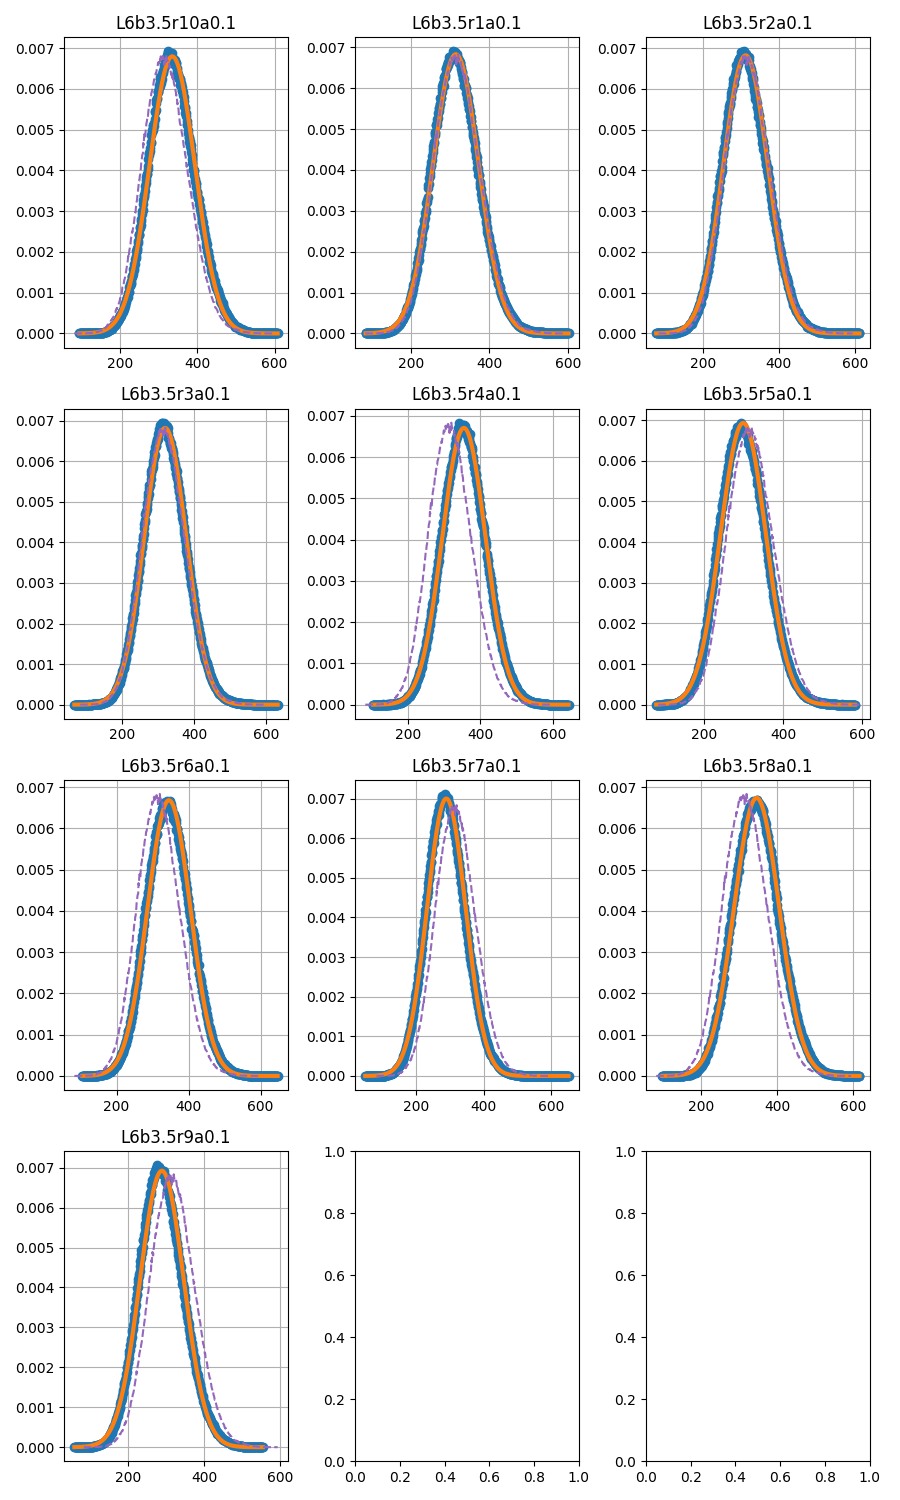

In [9]:
fnames = !ls ../runs/L6b3.5/nmnm*
fname_unif = '../repro_runs/m5.2L6/nmnm_m5.2L6b3.5_1.dat'
plot_nmnm(fnames, fname_unif)

### Analyze $L=6$, $\beta=4.0$

In [10]:
resdict_L6b40 = {"L": 6, "beta": 4.0}


reslines = !ls ../runs/L6b4.0/res*
print(reslines)
df = read_res(reslines)
df

['../runs/L6b4.0/res_L6b4.0r10a0.1.dat', '../runs/L6b4.0/res_L6b4.0r1a0.1.dat', '../runs/L6b4.0/res_L6b4.0r2a0.1.dat', '../runs/L6b4.0/res_L6b4.0r3a0.1.dat', '../runs/L6b4.0/res_L6b4.0r4a0.1.dat', '../runs/L6b4.0/res_L6b4.0r5a0.1.dat', '../runs/L6b4.0/res_L6b4.0r6a0.1.dat', '../runs/L6b4.0/res_L6b4.0r7a0.1.dat', '../runs/L6b4.0/res_L6b4.0r8a0.1.dat', '../runs/L6b4.0/res_L6b4.0r9a0.1.dat']


replica_id   density  err_density conv_density      g_im  err_g_im  \
0          10  0.175660     0.000326            T  0.128410  0.001170   
1           1  0.166466     0.000363            T  0.112788  0.001126   
2           2  0.165304     0.000466            T  0.111435  0.000985   
3           3  0.168792     0.000338            T  0.116663  0.000966   
4           4  0.184218     0.000468            T  0.138701  0.001351   
5           5  0.160488     0.000423            T  0.106015  0.001182   
6           6  0.178510     0.000425            T  0.130117  0.001100   
7           7  0.155898     0.000287            T  0.098597  0.000614   
8           8  0.179161     0.000394            T  0.131261  0.001097   
9           9  0.154484     0.000295            T  0.098301  0.000769   

  conv_g_im      Z(mln)  
0         T  139.880731  
1         F  141.410676  
2         T  135.703915  
3         T  137.180873  
4         T  112.222083  
5         F  141.753234  
6         T  100.424124  
7         T  205.733408  
8         T  105.112868  
9         T  222.716103

<IPython.core.display.Javascript object>


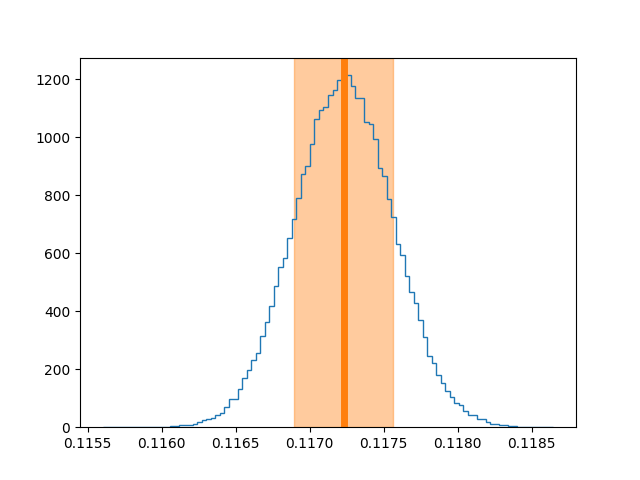

0.11722862313123726 +/- 0.0003334662184320553


In [11]:
samples = resample(df["g_im"], df["err_g_im"])
plt.hist(samples, density=True, bins=100, histtype='step')

m, s = samples.mean(), samples.std()

plt.axvline(m, lw=5, color='C1')
plt.axvspan(m-s, m+s, alpha=0.4, color='C1')

print(m, '+/-', s)
resdict_L6b40["g_im"] = m
resdict_L6b40["err_g_im"] = s

<IPython.core.display.Javascript object>


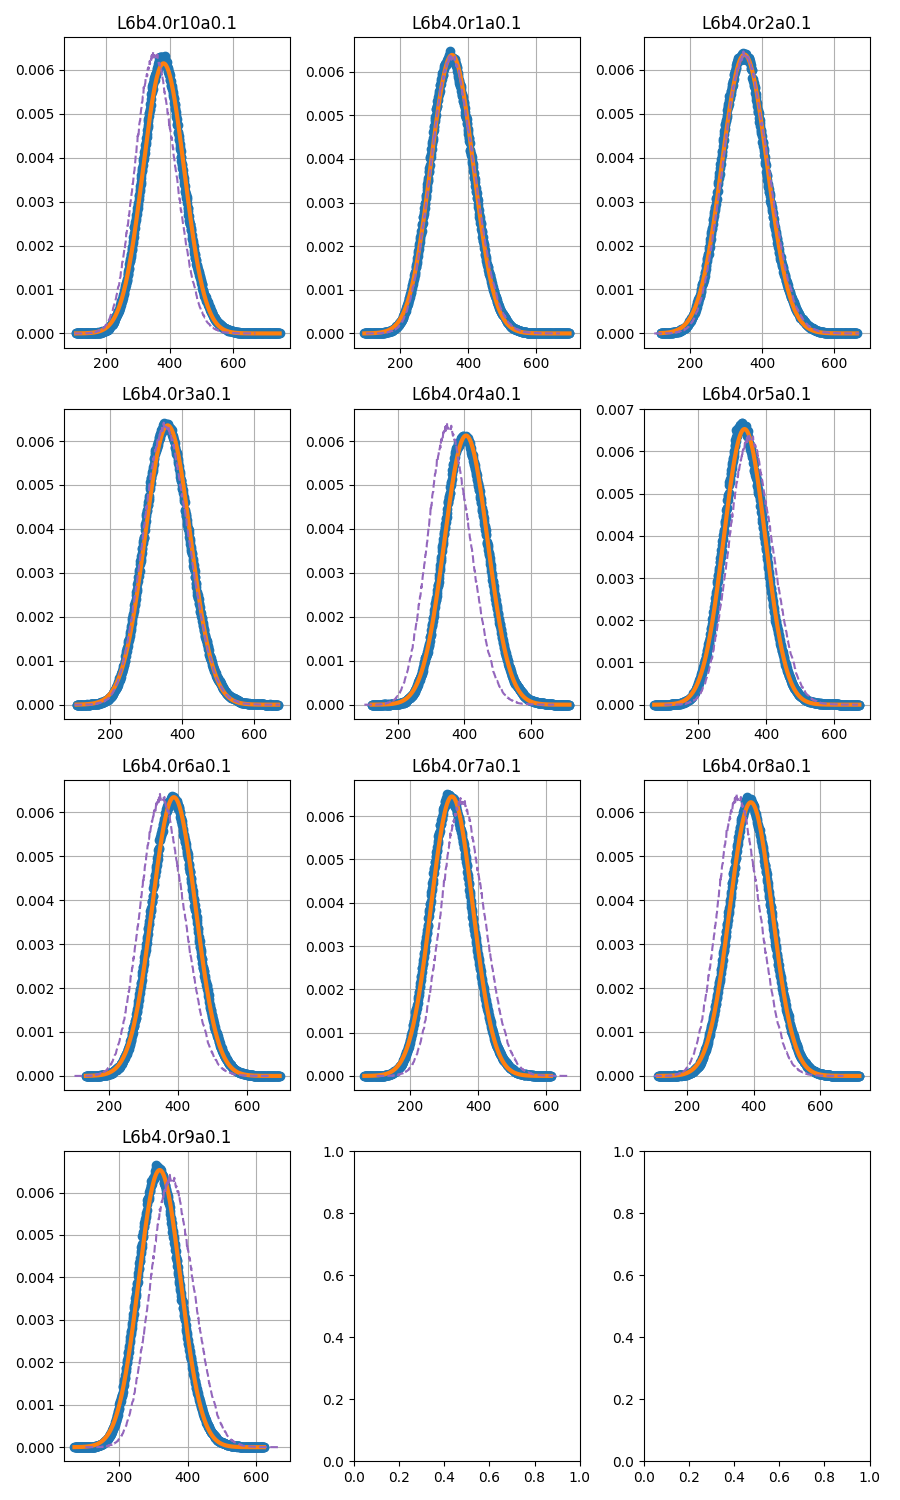

In [12]:
fnames = !ls ../runs/L6b4.0/nmnm*
fname_unif = '../repro_runs/m5.2L6/nmnm_m5.2L6b4.0_1.dat'
plot_nmnm(fnames, fname_unif)

### Analyze $L=6$, $\beta=4.5$

In [13]:
resdict_L6b45 = {"L": 6, "beta": 4.5}

reslines = !ls ../runs/L6b4.5/res*
print(reslines)
df = read_res(reslines)
df

['../runs/L6b4.5/res_L6b4.5r10a0.1.dat', '../runs/L6b4.5/res_L6b4.5r1a0.1.dat', '../runs/L6b4.5/res_L6b4.5r2a0.1.dat', '../runs/L6b4.5/res_L6b4.5r3a0.1.dat', '../runs/L6b4.5/res_L6b4.5r4a0.1.dat', '../runs/L6b4.5/res_L6b4.5r5a0.1.dat', '../runs/L6b4.5/res_L6b4.5r6a0.1.dat', '../runs/L6b4.5/res_L6b4.5r7a0.1.dat', '../runs/L6b4.5/res_L6b4.5r8a0.1.dat', '../runs/L6b4.5/res_L6b4.5r9a0.1.dat']


replica_id   density  err_density conv_density      g_im  err_g_im  \
0          10  0.176548     0.000393            T  0.173093  0.001959   
1           1  0.167219     0.000319            T  0.159794  0.001966   
2           2  0.165874     0.000338            T  0.154919  0.001312   
3           3  0.169848     0.000329            T  0.161567  0.001702   
4           4  0.184799     0.000544            T  0.184380  0.001887   
5           5  0.160663     0.000462            T  0.147883  0.001416   
6           6  0.181024     0.000457            T  0.180425  0.001976   
7           7  0.155684     0.000272            T  0.138793  0.001171   
8           8  0.181820     0.000565            T  0.181482  0.001545   
9           9  0.154334     0.000523            T  0.137258  0.001579   

  conv_g_im      Z(mln)  
0         T   56.518127  
1         F   89.079873  
2         T   76.791331  
3         T   78.858520  
4         T   53.465784  
5         T  100.252267  
6         T   67.024091  
7         T  122.756382  
8         T   66.709982  
9         T  134.391545

<IPython.core.display.Javascript object>


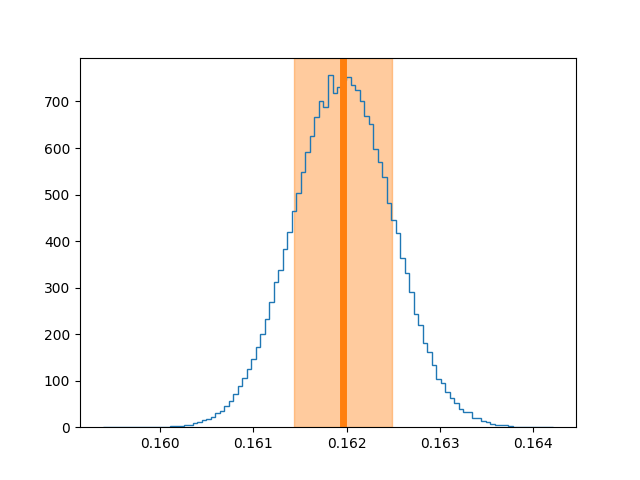

0.16195933205798857 +/- 0.0005283940158537283


In [14]:
samples = resample(df["g_im"], df["err_g_im"])
plt.hist(samples, density=True, bins=100, histtype='step')

m, s = samples.mean(), samples.std()

plt.axvline(m, lw=5, color='C1')
plt.axvspan(m-s, m+s, alpha=0.4, color='C1')

print(m, '+/-', s)
resdict_L6b45["g_im"] = m
resdict_L6b45["err_g_im"] = s

<IPython.core.display.Javascript object>


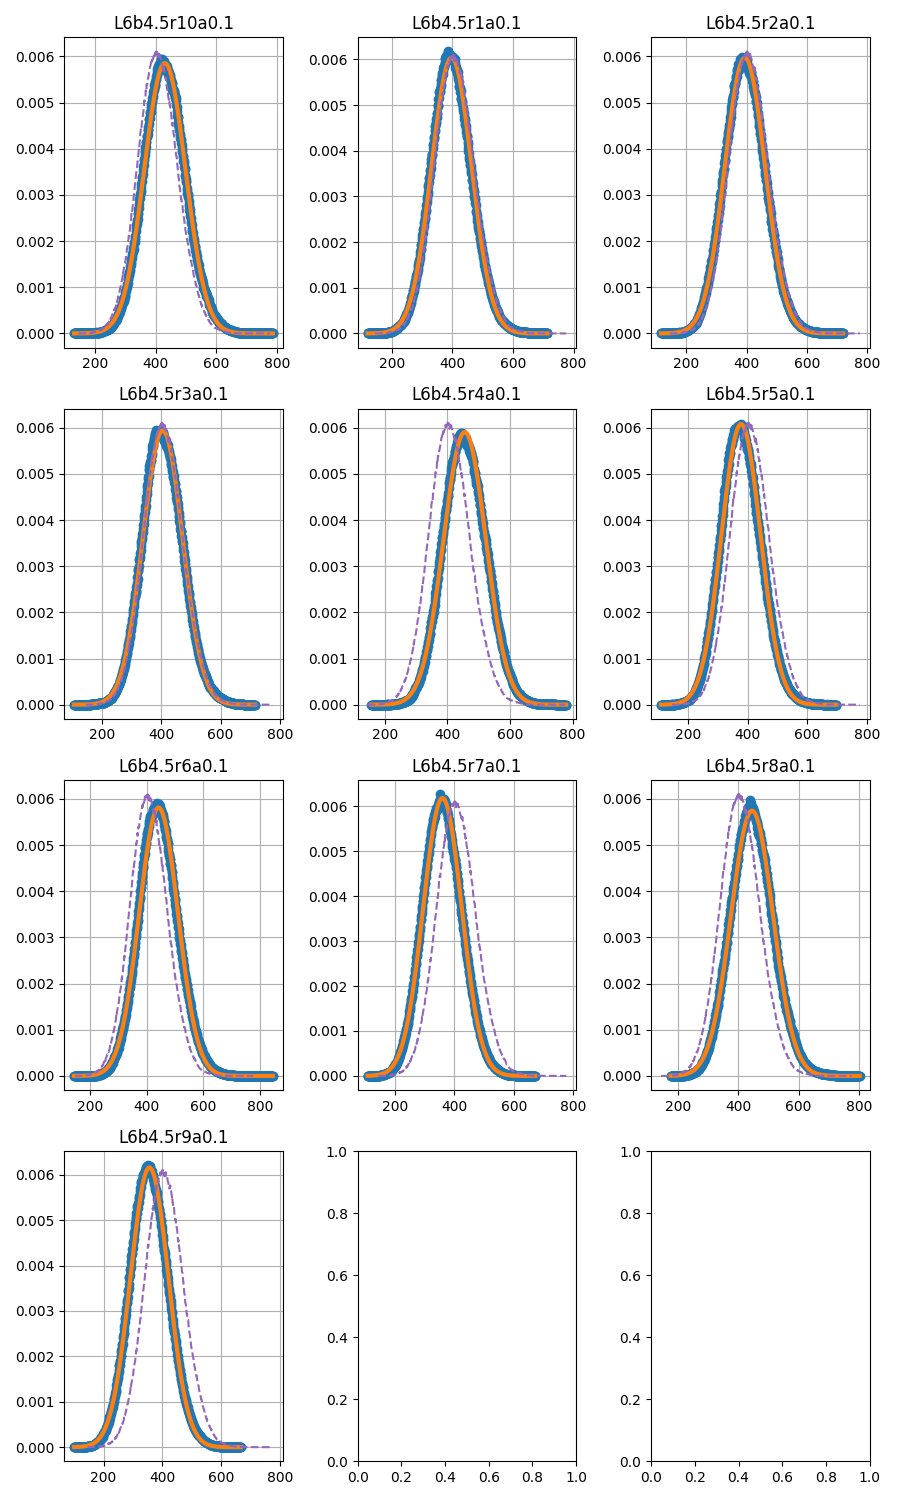

In [15]:
fnames = !ls ../runs/L6b4.5/nmnm*
fname_unif = '../repro_runs/m5.2L6/nmnm_m5.2L6b4.5_1.dat'
plot_nmnm(fnames, fname_unif)

## collect L=6 

In [16]:
df = pd.DataFrame([resdict_L6b35, resdict_L6b40, resdict_L6b45])
df

L  beta      g_im  err_g_im
0  6   3.5  0.072736  0.000177
1  6   4.0  0.117229  0.000333
2  6   4.5  0.161959  0.000528

In [17]:
# SAVE L=6
df.to_csv("m5.2L6_av_replicas.dat")
print(df.to_csv())

,L,beta,g_im,err_g_im
0,6,3.5,0.07273619241738194,0.0001769013784177102
1,6,4.0,0.11722862313123726,0.0003334662184320553
2,6,4.5,0.16195933205798857,0.0005283940158537283



# Read in L=6 simulations

In [19]:
df_L6 = pd.read_csv("m5.2L6_av_replicas.dat")
df_L6

Unnamed: 0  L  beta      g_im  err_g_im
0           0  6   3.5  0.072736  0.000177
1           1  6   4.0  0.117229  0.000333
2           2  6   4.5  0.161959  0.000528

# Process L=8 simulations


### Analyze $L=8$, $\beta = 4.0$

In [100]:
resdict_L8b40 = {"L": 8, "beta": 4.0}


reslines = !ls ../runs/L8b4.0/res*
print(reslines)
df = read_res(reslines)
df

['../runs/L8b4.0/res_L8b4.0r10a0.1.dat', '../runs/L8b4.0/res_L8b4.0r1a0.1.dat', '../runs/L8b4.0/res_L8b4.0r2a0.1.dat', '../runs/L8b4.0/res_L8b4.0r3a0.1.dat', '../runs/L8b4.0/res_L8b4.0r4a0.1.dat', '../runs/L8b4.0/res_L8b4.0r5a0.1.dat', '../runs/L8b4.0/res_L8b4.0r6a0.1.dat', '../runs/L8b4.0/res_L8b4.0r7a0.1.dat', '../runs/L8b4.0/res_L8b4.0r8a0.1.dat', '../runs/L8b4.0/res_L8b4.0r9a0.1.dat']


replica_id   density  err_density conv_density      g_im  err_g_im  \
0          10  0.174789     0.003486            T  0.136660  0.008958   
1           1  0.164855     0.002423            T  0.109284  0.008552   
2           2  0.161578     0.001621            F  0.112685  0.007237   
3           3  0.167519     0.002172            T  0.122792  0.012108   
4           4  0.174669     0.001948            T  0.127195  0.010534   
5           5  0.153605     0.001481            T  0.086315  0.003808   
6           6  0.175441     0.004406            T  0.141278  0.011251   
7           7  0.153436     0.001577            T  0.080002  0.004443   
8           8  0.168737     0.001941            T  0.126608  0.010556   
9           9  0.149082     0.001597            T  0.078128  0.003107   

  conv_g_im     Z(mln)  
0         T   3.624405  
1         F   5.278254  
2         F   5.955630  
3         F   4.547941  
4         T   3.982398  
5         T   8.880700  
6         T   3.822174  
7         F   8.428445  
8         T   4.106250  
9         T  10.756733

<IPython.core.display.Javascript object>


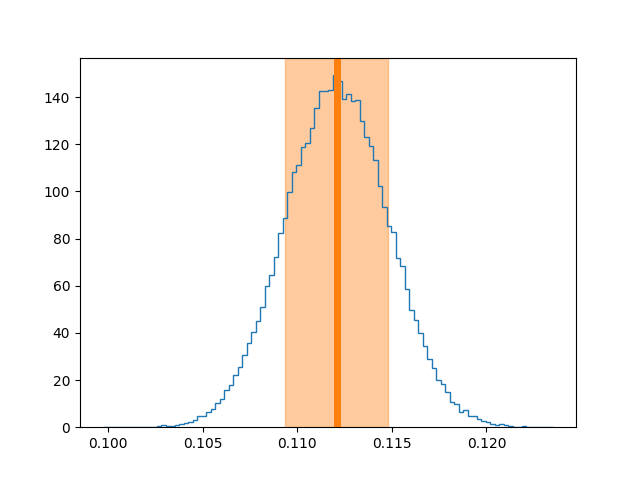

0.1120941602667597 +/- 0.0027268899162202088


In [101]:
samples = resample(df["g_im"], df["err_g_im"])
plt.hist(samples, density=True, bins=100, histtype='step')

m, s = samples.mean(), samples.std()

plt.axvline(m, lw=5, color='C1')
plt.axvspan(m-s, m+s, alpha=0.4, color='C1')

print(m, '+/-', s)
resdict_L8b40["g_im"] = m
resdict_L8b40["err_g_im"] = s

<IPython.core.display.Javascript object>


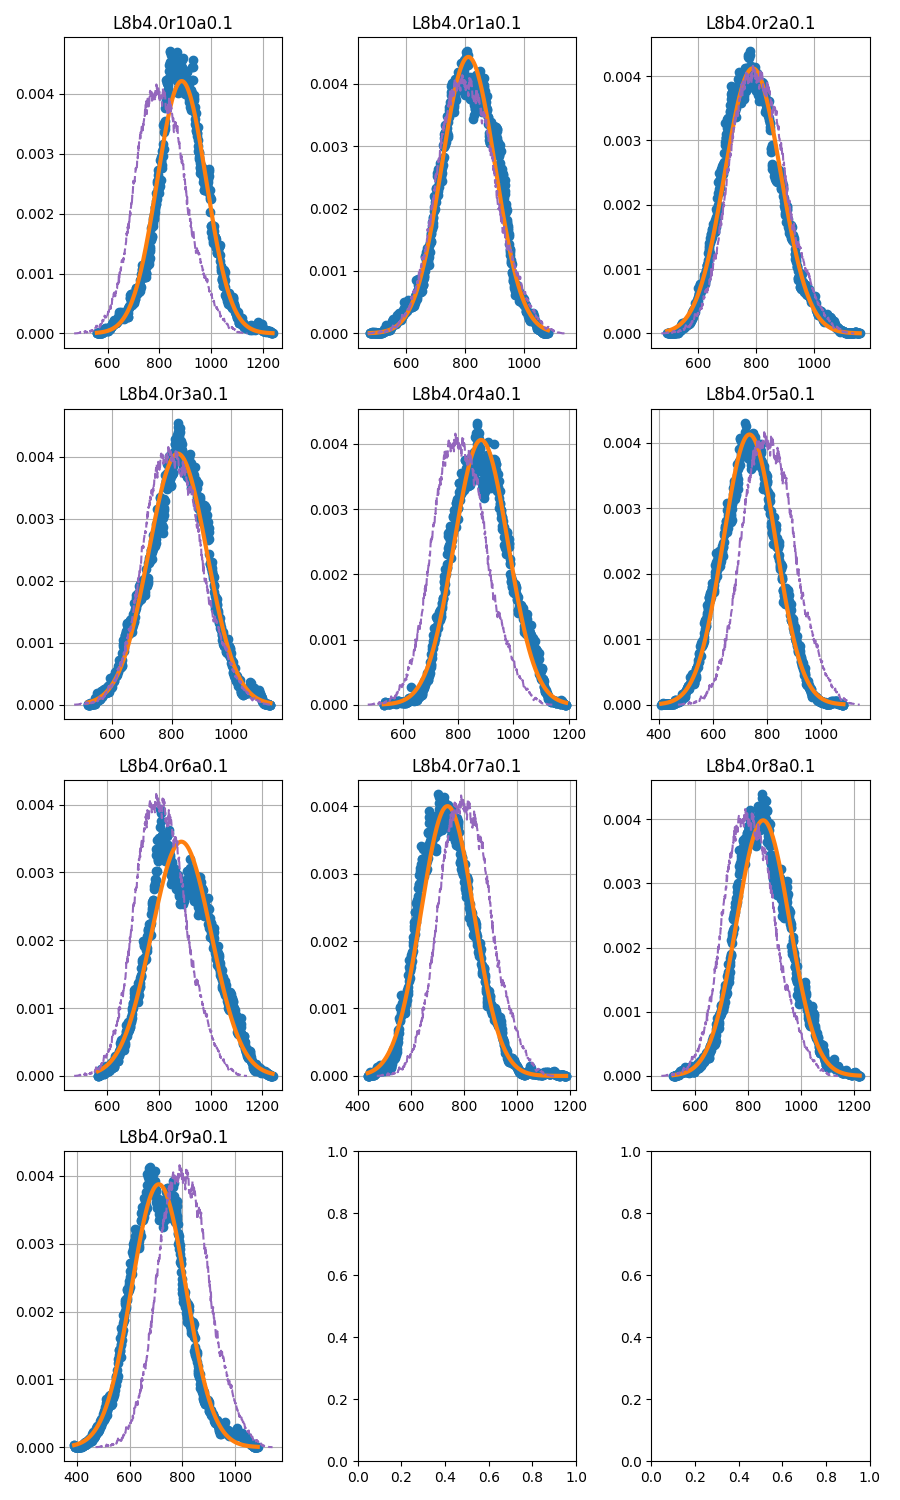

In [102]:
fnames = !ls ../runs/L8b4.0/nmnm*
fname_unif = '../repro_runs/m5.2L8/nmnm_m5.2L8b4.0_1.dat'
plot_nmnm(fnames, fname_unif)

### Analyze $L=8$, $\beta = 4.25$

In [104]:
resdict_L8b425 = {"L": 8, "beta": 4.25}

reslines = !ls ../runs/L8b4.25/res*
print(reslines)
df = read_res(reslines)
df

['../runs/L8b4.25/res_L8b4.25r10a0.1.dat', '../runs/L8b4.25/res_L8b4.25r1a0.1.dat', '../runs/L8b4.25/res_L8b4.25r2a0.1.dat', '../runs/L8b4.25/res_L8b4.25r3a0.1.dat', '../runs/L8b4.25/res_L8b4.25r4a0.1.dat', '../runs/L8b4.25/res_L8b4.25r5a0.1.dat', '../runs/L8b4.25/res_L8b4.25r6a0.1.dat', '../runs/L8b4.25/res_L8b4.25r7a0.1.dat', '../runs/L8b4.25/res_L8b4.25r8a0.1.dat', '../runs/L8b4.25/res_L8b4.25r9a0.1.dat']


replica_id   density  err_density conv_density      g_im  err_g_im  \
0          10  0.170121     0.001692            F  0.154142  0.009328   
1           1  0.164009     0.002044            T  0.134437  0.006993   
2           2  0.162883     0.001627            T  0.133355  0.011564   
3           3  0.165178     0.001267            F  0.148807  0.010702   
4           4  0.177721     0.002886            T  0.197612  0.017547   
5           5  0.158491     0.001447            T  0.134245  0.007283   
6           6  0.172680     0.001612            T  0.144075  0.009109   
7           7  0.150795     0.001973            F  0.124959  0.006003   
8           8  0.176441     0.001849            T  0.176162  0.011217   
9           9  0.147237     0.000821            T  0.107826  0.003158   

  conv_g_im     Z(mln)  
0         T   5.053870  
1         T   3.885351  
2         T   3.754357  
3         T   3.050970  
4         T   2.134172  
5         F   4.548784  
6         T   2.978193  
7         F   5.397018  
8         T   2.337931  
9         T  14.960398

<IPython.core.display.Javascript object>


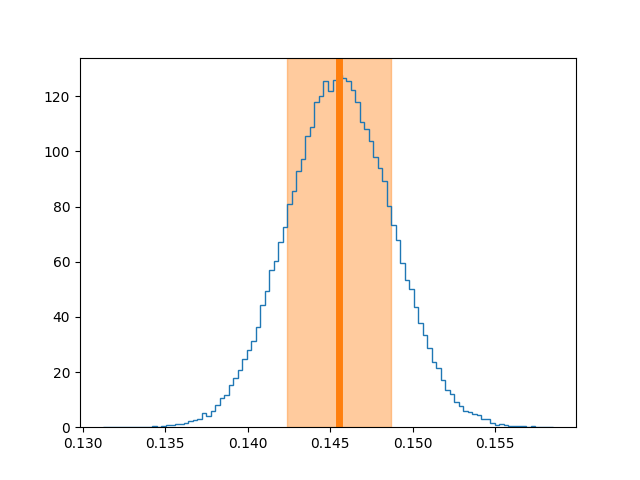

0.14556163650935455 +/- 0.0031612480388744863


In [105]:
samples = resample(df["g_im"], df["err_g_im"])
plt.hist(samples, density=True, bins=100, histtype='step')

m, s = samples.mean(), samples.std()

plt.axvline(m, lw=5, color='C1')
plt.axvspan(m-s, m+s, alpha=0.4, color='C1')

print(m, '+/-', s)
resdict_L8b425["g_im"] = m
resdict_L8b425["err_g_im"] = s

<IPython.core.display.Javascript object>


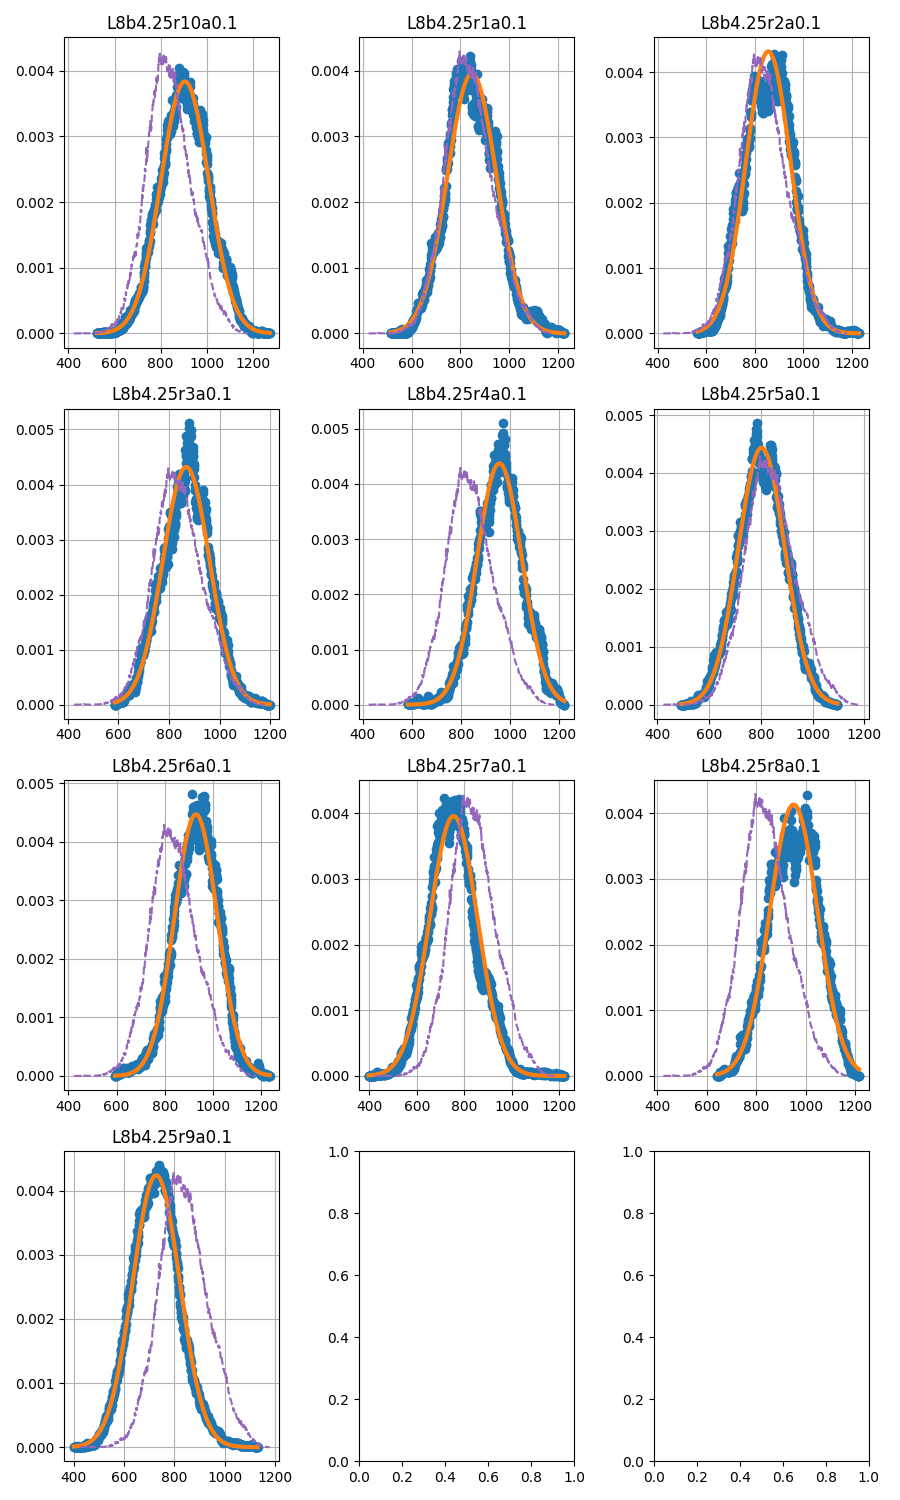

In [106]:
fnames = !ls ../runs/L8b4.25/nmnm*
fname_unif = '../repro_runs/m5.2L8/nmnm_m5.2L8b4.25_1.dat'
plot_nmnm(fnames, fname_unif)

### Analyze $L=8$, $\beta = 4.5$

In [107]:
resdict_L8b45 = {"L": 8, "beta": 4.5}

reslines = !ls ../runs/L8b4.5/res*
print(reslines)
df = read_res(reslines)
df

['../runs/L8b4.5/res_L8b4.5r10a0.1.dat', '../runs/L8b4.5/res_L8b4.5r1a0.1.dat', '../runs/L8b4.5/res_L8b4.5r2a0.1.dat', '../runs/L8b4.5/res_L8b4.5r3a0.1.dat', '../runs/L8b4.5/res_L8b4.5r4a0.1.dat', '../runs/L8b4.5/res_L8b4.5r5a0.1.dat', '../runs/L8b4.5/res_L8b4.5r6a0.1.dat', '../runs/L8b4.5/res_L8b4.5r7a0.1.dat', '../runs/L8b4.5/res_L8b4.5r8a0.1.dat', '../runs/L8b4.5/res_L8b4.5r9a0.1.dat']


replica_id   density  err_density conv_density      g_im  err_g_im  \
0          10  0.171804     0.001096            T  0.198321  0.006647   
1           1  0.161519     0.001237            T  0.179504  0.008671   
2           2  0.165414     0.001464            T  0.188530  0.012117   
3           3  0.167740     0.001542            T  0.185219  0.008475   
4           4  0.176529     0.002456            F  0.204364  0.010919   
5           5  0.155462     0.001422            T  0.170234  0.008315   
6           6  0.176477     0.002382            F  0.207903  0.014224   
7           7  0.152080     0.001624            T  0.147679  0.011913   
8           8  0.174262     0.001361            F  0.210224  0.010426   
9           9  0.148656     0.000818            T  0.139451  0.004226   

  conv_g_im    Z(mln)  
0         T  8.785985  
1         T  4.635688  
2         T  3.751809  
3         T  3.633172  
4         F  2.835802  
5         F  5.559171  
6         T  2.571630  
7         T  7.829625  
8         F  2.852498  
9         T  9.532507

<IPython.core.display.Javascript object>


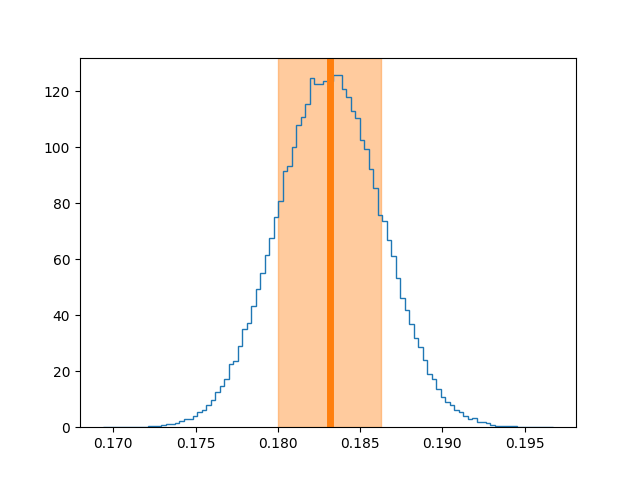

0.1831402157217281 +/- 0.003154608735368523


In [108]:
samples = resample(df["g_im"], df["err_g_im"])
plt.hist(samples, density=True, bins=100, histtype='step')

m, s = samples.mean(), samples.std()

plt.axvline(m, lw=5, color='C1')
plt.axvspan(m-s, m+s, alpha=0.4, color='C1')

print(m, '+/-', s)
resdict_L8b45["g_im"] = m
resdict_L8b45["err_g_im"] = s

<IPython.core.display.Javascript object>


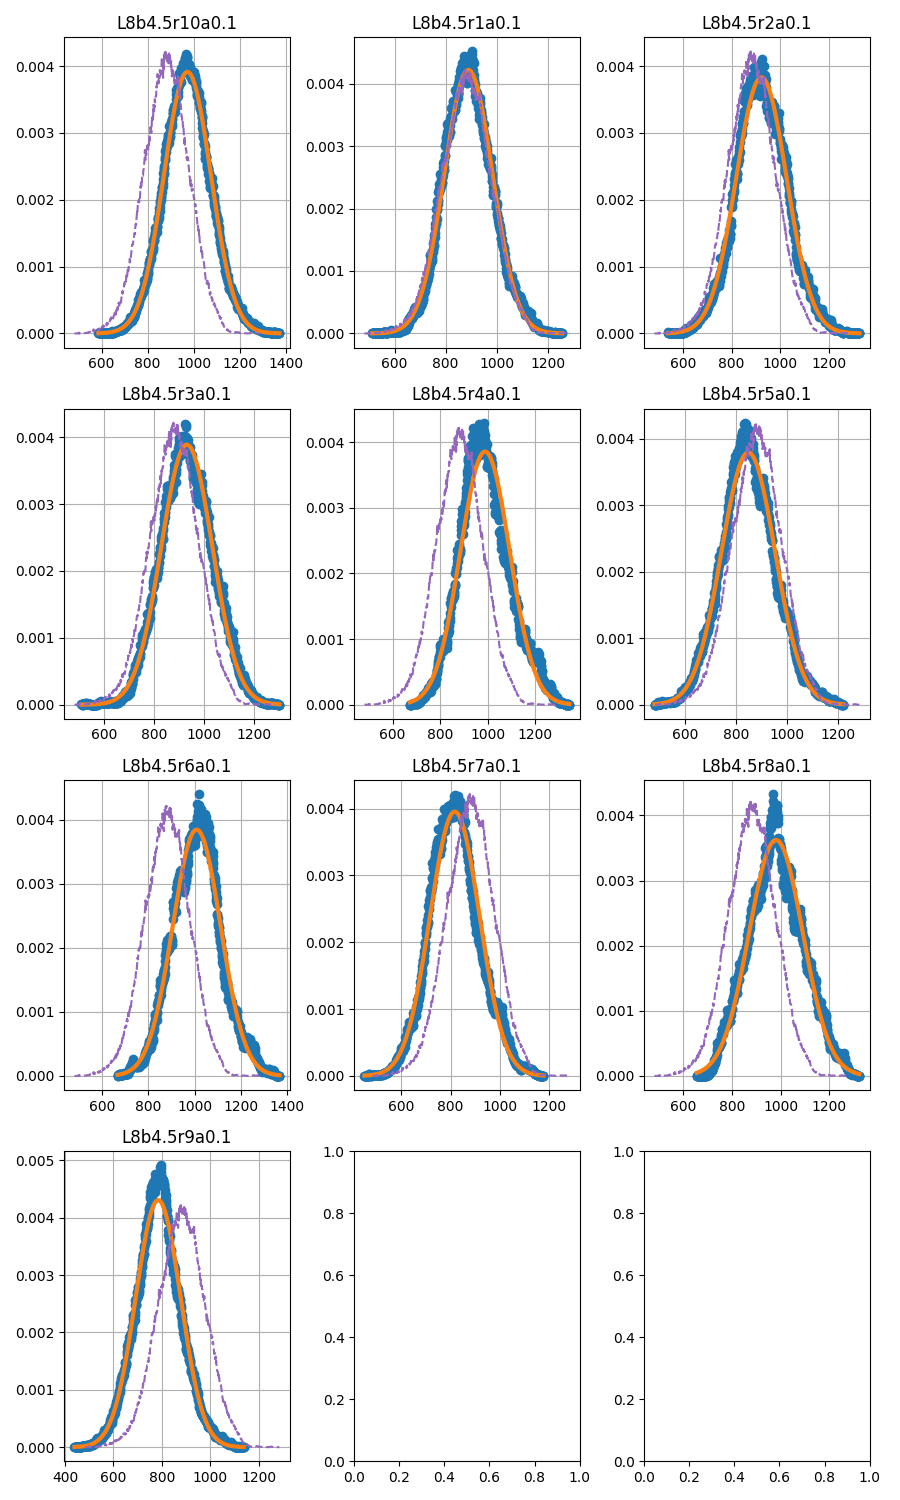

In [109]:
fnames = !ls ../runs/L8b4.5/nmnm*
fname_unif = '../repro_runs/m5.2L8/nmnm_m5.2L8b4.5_1.dat'
plot_nmnm(fnames, fname_unif)

## collect L=8

In [110]:
df = pd.DataFrame([resdict_L8b40, resdict_L8b425, resdict_L8b45])
df.to_csv("m5.2L8_av_replicas.dat")
df

L  beta      g_im  err_g_im
0  8  4.00  0.112094  0.002727
1  8  4.25  0.145562  0.003161
2  8  4.50  0.183140  0.003155

In [111]:
df_L6L8 = pd.concat([df_L6, df])
df_L6L8

Unnamed: 0  L  beta      g_im  err_g_im
0         0.0  6  3.50  0.072736  0.000177
1         1.0  6  4.00  0.117229  0.000333
2         2.0  6  4.50  0.161959  0.000528
0         NaN  8  4.00  0.112094  0.002727
1         NaN  8  4.25  0.145562  0.003161
2         NaN  8  4.50  0.183140  0.003155

In [48]:
df_L6L8.columns

Index(['Unnamed: 0', 'L', 'beta', 'g_im', 'err_g_im'], dtype='object')

In [49]:
df_L6L8[['L', 'beta', 'g_im', 'err_g_im']].to_csv()

L  beta      g_im  err_g_im
0  6  3.50  0.072736  0.000177
1  6  4.00  0.117229  0.000333
2  6  4.50  0.161959  0.000528
0  8  4.00  0.105720  0.001672
1  8  4.25  0.144587  0.003372
2  8  4.50  0.185077  0.004055

# Process L=12 simulations


### Analyze $L=12$, $\beta = 4.2$

In [8]:
resdict_L12b42 = {"L": 12, "beta": 4.2}

reslines = !ls ../runs/L12b4.2/res*
print(reslines)
df = read_res(reslines)
df

['../runs/L12b4.2/res_L12b4.2r10a0.1.dat', '../runs/L12b4.2/res_L12b4.2r1a0.1.dat', '../runs/L12b4.2/res_L12b4.2r2a0.1.dat', '../runs/L12b4.2/res_L12b4.2r3a0.1.dat', '../runs/L12b4.2/res_L12b4.2r4a0.1.dat', '../runs/L12b4.2/res_L12b4.2r5a0.1.dat', '../runs/L12b4.2/res_L12b4.2r6a0.1.dat', '../runs/L12b4.2/res_L12b4.2r7a0.1.dat', '../runs/L12b4.2/res_L12b4.2r8a0.1.dat', '../runs/L12b4.2/res_L12b4.2r9a0.1.dat']


replica_id   density  err_density conv_density      g_im  err_g_im  \
0          10  0.162854     0.002263            T  0.131139  0.017204   
1           1  0.155463     0.001303            T  0.116650  0.011881   
2           2  0.151858     0.001480            T  0.087880  0.006015   
3           3  0.160459     0.001824            T  0.151477  0.014083   
4           4  0.164919     0.001626            T  0.122779  0.016251   
5           5  0.150871     0.002031            T  0.104593  0.006685   
6           6  0.163165     0.001634            T  0.147534  0.011821   
7           7  0.144145     0.000860            T  0.064665  0.004532   
8           8  0.162801     0.003067            T  0.123923  0.010283   
9           9  0.142516     0.001052            T  0.067763  0.005172   

  conv_g_im    Z(mln)  
0         F  2.371037  
1         T  3.019860  
2         T  4.020300  
3         T  1.971879  
4         T  2.531711  
5         T  3.621069  
6         T  2.162435  
7         T  4.852836  
8         T  2.382362  
9         T  6.731547

<IPython.core.display.Javascript object>


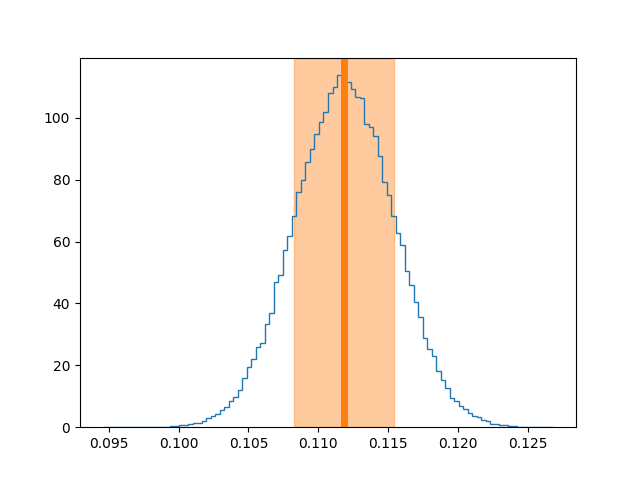

0.11184181568697571 +/- 0.003562869290364116


In [9]:
samples = resample(df["g_im"], df["err_g_im"])
plt.hist(samples, density=True, bins=100, histtype='step')

m, s = samples.mean(), samples.std()

plt.axvline(m, lw=5, color='C1')
plt.axvspan(m-s, m+s, alpha=0.4, color='C1')

print(m, '+/-', s)
resdict_L12b42["g_im"] = m
resdict_L12b42["err_g_im"] = s

<IPython.core.display.Javascript object>


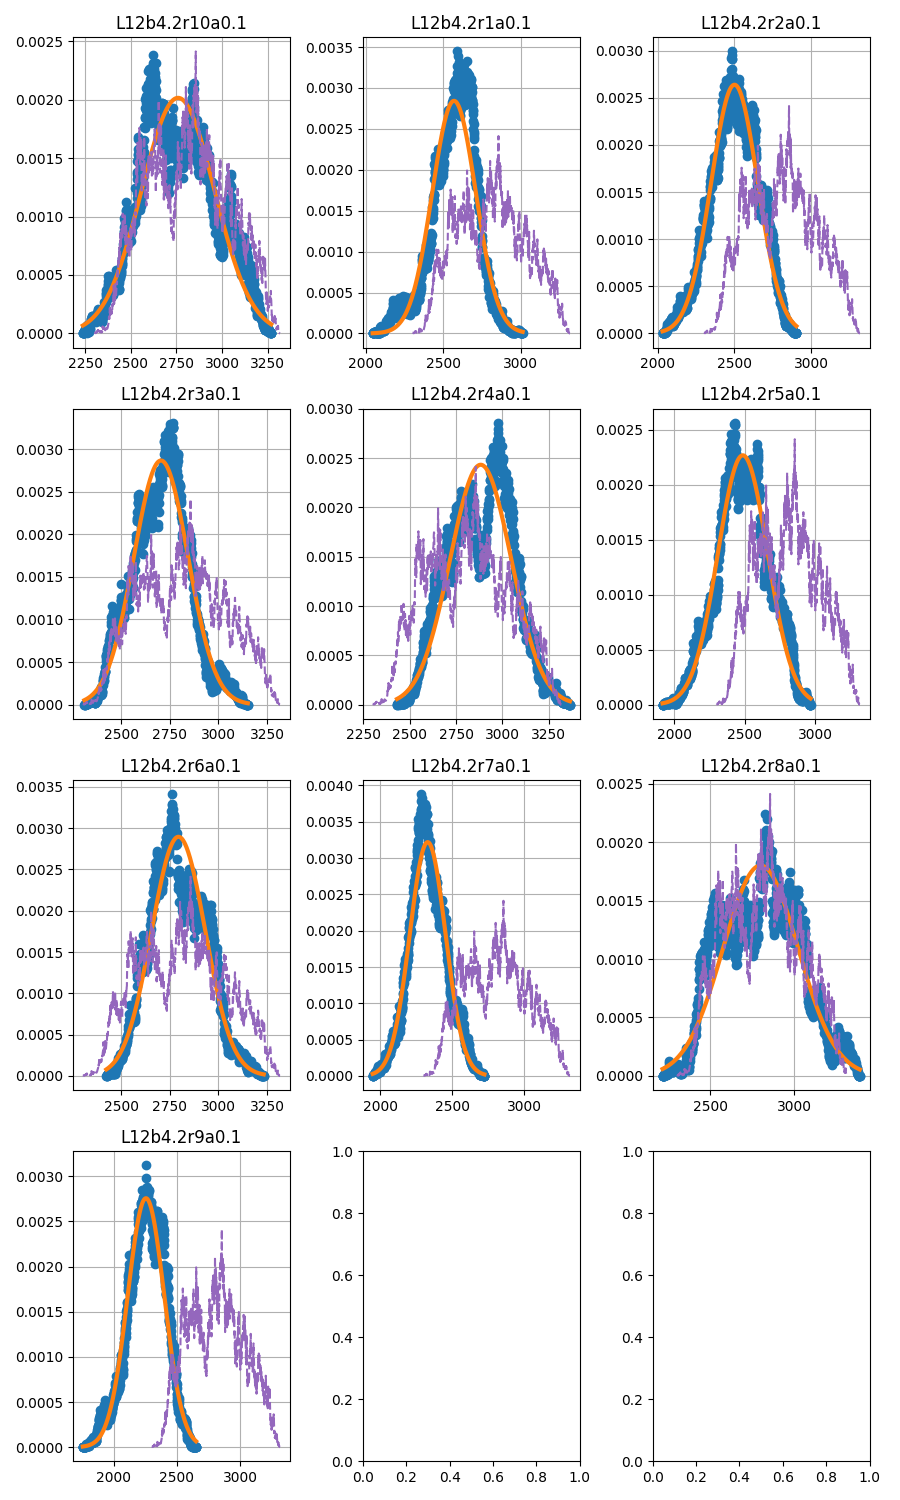

In [10]:
fnames = !ls ../runs/L12b4.2/nmnm*
fname_unif = '../repro_runs/m5.2L12/nmnm_m5.2L12b4.2_1.dat'
plot_nmnm(fnames, fname_unif)

### Analyze $L=12$, $\beta = 4.55$

In [11]:
resdict_L12b455 = {"L": 12, "beta": 4.55}

reslines = !ls ../runs/L12b4.55/res*
print(reslines)
df = read_res(reslines)
df

['../runs/L12b4.55/res_L12b4.55r10a0.1.dat', '../runs/L12b4.55/res_L12b4.55r1a0.1.dat', '../runs/L12b4.55/res_L12b4.55r2a0.1.dat', '../runs/L12b4.55/res_L12b4.55r3a0.1.dat', '../runs/L12b4.55/res_L12b4.55r4a0.1.dat', '../runs/L12b4.55/res_L12b4.55r5a0.1.dat', '../runs/L12b4.55/res_L12b4.55r6a0.1.dat', '../runs/L12b4.55/res_L12b4.55r7a0.1.dat', '../runs/L12b4.55/res_L12b4.55r8a0.1.dat', '../runs/L12b4.55/res_L12b4.55r9a0.1.dat']


replica_id   density  err_density conv_density      g_im  err_g_im  \
0          10  0.161411     0.001159            T  0.217981  0.017849   
1           1  0.152388     0.002333            T  0.183999  0.017507   
2           2  0.154408     0.001577            F  0.211616  0.023259   
3           3  0.166866     0.002274            T  0.257630  0.023689   
4           4  0.166639     0.001550            T  0.258517  0.039128   
5           5  0.150715     0.001312            T  0.194378  0.024082   
6           6  0.165475     0.001421            T  0.270080  0.034245   
7           7  0.144861     0.000886            T  0.164490  0.015028   
8           8  0.164677     0.002122            T  0.257174  0.032954   
9           9  0.143132     0.000903            T  0.151571  0.012503   

  conv_g_im    Z(mln)  
0         T  1.732981  
1         T  1.521625  
2         T  1.342475  
3         T  0.931306  
4         T  0.871369  
5         T  1.504886  
6         T  0.839661  
7         T  1.898545  
8         T  0.875465  
9         T  1.788361

<IPython.core.display.Javascript object>


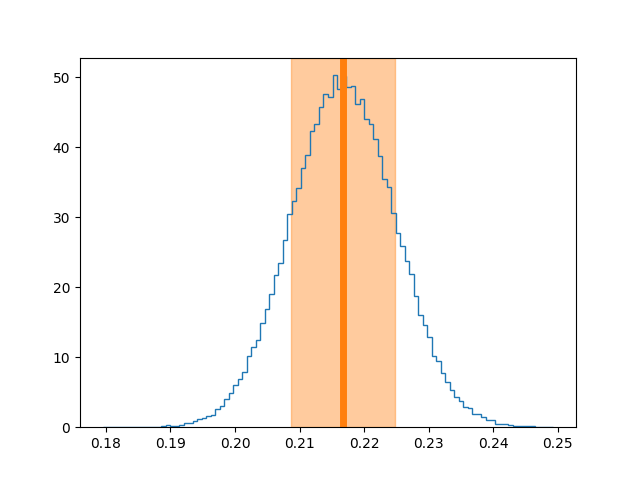

0.21674541075528872 +/- 0.008045407539543468


In [12]:
samples = resample(df["g_im"], df["err_g_im"])
plt.hist(samples, density=True, bins=100, histtype='step')

m, s = samples.mean(), samples.std()

plt.axvline(m, lw=5, color='C1')
plt.axvspan(m-s, m+s, alpha=0.4, color='C1')

print(m, '+/-', s)
resdict_L12b455["g_im"] = m
resdict_L12b455["err_g_im"] = s

<IPython.core.display.Javascript object>


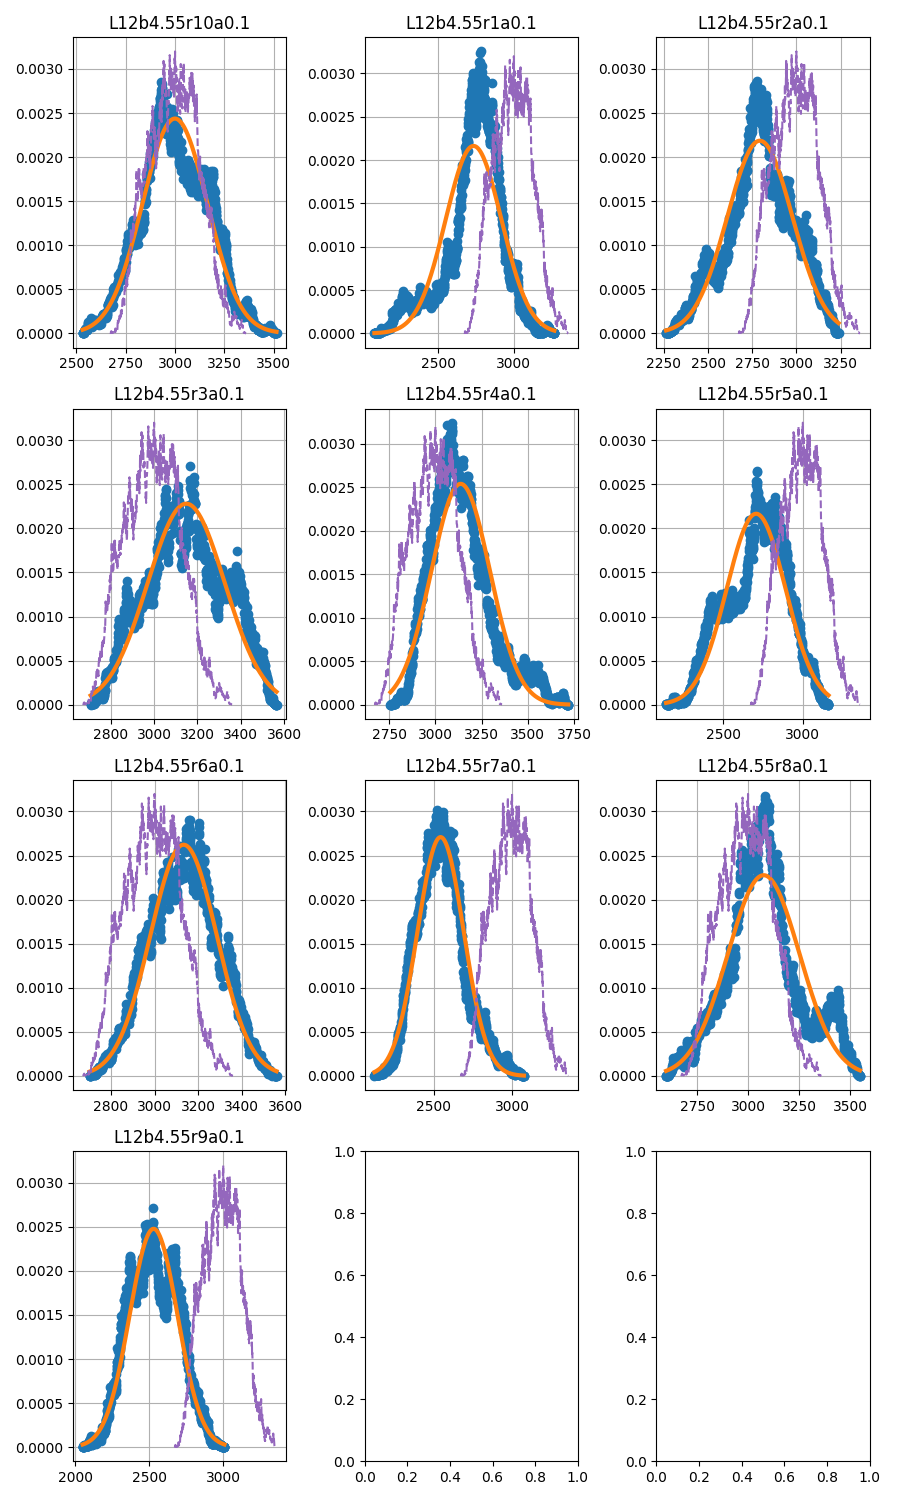

In [13]:
fnames = !ls ../runs/L12b4.55/nmnm*
fname_unif = '../repro_runs/m5.2L12/nmnm_m5.2L12b4.55_1.dat'
plot_nmnm(fnames, fname_unif)

In [14]:
df = pd.DataFrame([resdict_L12b42, resdict_L12b455])
df.to_csv("m5.2L12_av_replicas.dat")
df

L  beta      g_im  err_g_im
0  12  4.20  0.111842  0.003563
1  12  4.55  0.216745  0.008045

## Read in L=6, 8

In [16]:
!ls *dat

m5.2L12_av_replicas.dat  m5.2L6_av_replicas.dat  m5.2L8_av_replicas.dat


In [18]:
df_L6 = pd.read_csv("m5.2L6_av_replicas.dat")
df_L8 = pd.read_csv("m5.2L8_av_replicas.dat")
df_L12 = pd.read_csv("m5.2L12_av_replicas.dat")
df_L6L8L12 = pd.concat([df_L6, df_L8, df_L12])
df_L6L8L12

Unnamed: 0   L  beta      g_im  err_g_im
0           0   6  3.50  0.072736  0.000177
1           1   6  4.00  0.117229  0.000333
2           2   6  4.50  0.161959  0.000528
0           0   8  4.00  0.112094  0.002727
1           1   8  4.25  0.145562  0.003161
2           2   8  4.50  0.183140  0.003155
0           0  12  4.20  0.111842  0.003563
1           1  12  4.55  0.216745  0.008045

In [15]:
df_L6L8L12 = pd.concat([df_L6L8[df.columns], df])
df_L6L8L12

NameError: name 'df_L6L8' is not defined

# Compare to the uniform simulations

In [19]:
!ls ../repro_data

fit_tc.ipynb  m5.2.dat	README


In [20]:
df_uniform = pd.read_csv("../repro_data/m5.2.dat", sep="\s+")
df_uniform

#L  beta     g_im  err_g_im  density  err_density      Z
0    6  3.50  0.07180    0.0004  0.17092     0.000254  275.0
1    6  4.00  0.11677    0.0008  0.16756     0.000500  129.0
2    6  4.50  0.16630    0.0020  0.17051     0.000200   64.0
3    6  5.00  0.19430    0.0019  0.17178     0.000400   40.0
4    8  3.50  0.04631    0.0016  0.16549     0.002000   24.5
5    8  4.00  0.10630    0.0012  0.16300     0.000500  121.0
6    8  4.25  0.13750    0.0020  0.16000     0.000300  128.2
7    8  4.50  0.17200    0.0015  0.16190     0.000400   88.0
8    8  5.00  0.22460    0.0120  0.16665     0.002000    2.0
9   12  4.20  0.12200    0.0032  0.15770     0.000800   58.0
10  12  4.55  0.22700    0.0050  0.16000     0.000900   26.3

<IPython.core.display.Javascript object>


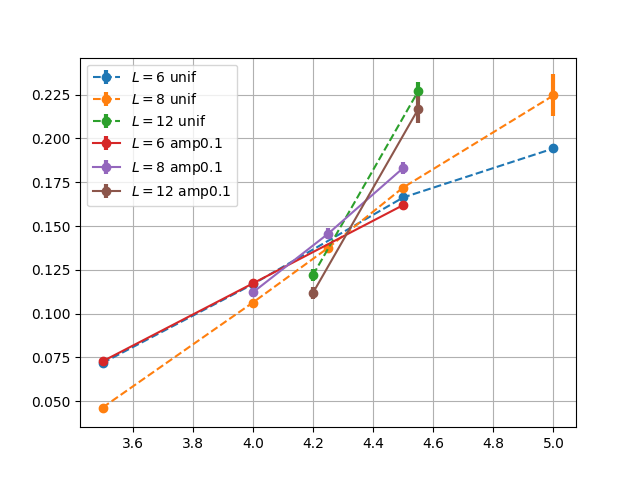

In [21]:
fig, ax = plt.subplots(1, 1)

for L, grp in df_uniform.groupby("#L"):
    ax.errorbar(grp["beta"], grp["g_im"], yerr=grp["err_g_im"],
                fmt='o--', elinewidth=3, label=r"$L=%s$ unif" % L)
    
for L, grp in df_L6L8L12.groupby("L"):
    ax.errorbar(grp["beta"], grp["g_im"], yerr=grp["err_g_im"],
                fmt='o-', elinewidth=3, label=r"$L=%s$ amp0.1" % L)

ax.legend(loc='best')
plt.grid(True)
plt.show()

In [123]:
df_L6L8L12

L  beta      g_im  err_g_im
0   6  3.50  0.072736  0.000177
1   6  4.00  0.117229  0.000333
2   6  4.50  0.161959  0.000528
0   8  4.00  0.112094  0.002727
1   8  4.25  0.145562  0.003161
2   8  4.50  0.183140  0.003155
0  12  4.20       NaN       NaN
1  12  4.55  0.187072  0.018677